# Pretraining analysis

The goal of this notebook is to test the efficacity of the pretraining done on the encoder with a subset of the MLCommons dataset.

## Utils

In [20]:
import sys
sys.path.append('../')

import torch
from dataset import SpeechCommandsData
from transforms import MfccTransform,Scattering
import models
from kymatio.torch import Scattering1D
import umap
import pathlib
import umap.plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report
from IPython.display import display_html
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
import plotly.graph_objects as go
%matplotlib inline

In [2]:
def speech_commands_collate(batch):
    """Collate function for setting up the dataloader

    Args:
        batch (int): batch size

    Returns:
        batch: return batched data in the form ; tensors,targets
    """
    tensors, targets, t_labels = [], [], []
    for waveform, label, rate, sid, uid in batch:
        if isinstance(waveform,np.ndarray):
            tensors += [torch.from_numpy(waveform)]
        elif isinstance(waveform, torch.Tensor):
            tensors += [waveform]
        else:
            raise ValueError("Waveform must be saved as torch.tensor or np.array")
        targets += [torch.tensor(label)]

    tensors = [item.t() for item in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(
        tensors, batch_first=True, padding_value=0.0
    )
    
    targets = torch.stack(targets)

    return tensors, targets

def predict(model,input):
    return torch.nn.functional.softmax(model(input),dim=-1).squeeze().argmax(dim=-1)

@torch.no_grad()
def extract_logits(model, dataloader):
  logits_buffer = []
  label_buffer = []

  for batch in tqdm(dataloader):
    audio_signal, labels = batch
  
    logits_buffer.append(model(audio_signal.squeeze()))
    label_buffer.append(labels)
  
  logits = torch.cat(logits_buffer, 0)
  labels = torch.cat(label_buffer, 0)
  return logits, labels

@torch.no_grad()
def count_correct(model,dataloader):
    correct=torch.zeros(35)
    total=torch.zeros(35)
    for batch in tqdm(dataloader):
        audio,labels=batch
        res=torch.eq(predict(model=model,input=audio),labels)
        for it,equality in enumerate(res):
            total[labels[it]]+=1
            if equality:
                correct[labels[it]]+=1
            
    return correct,total

## Model

Load and test the sepratation of the encoder on SpeechCommands

In [3]:
device = torch.device("cpu")

#Load model
PATH='./models/pretrained2.pt'
model=torch.nn.Sequential( Scattering(),models.EncDecBaseModel(num_mels=50,num_classes=70,final_filter=128,input_length=1000))
model.load_state_dict(torch.load(PATH))
model=torch.nn.Sequential(model[0],model[1].encoder,models.Pool(128))
model.to(device)

model.eval()

Sequential(
  (0): Scattering(
    (scattering): Scattering1D()
    (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvASREncoder(
    (conv_block_1): ConvBlock(
      (mconv): ModuleList(
        (0): Conv1d(50, 50, kernel_size=(11,), stride=(1,), padding=(5,), groups=50, bias=False)
        (1): Conv1d(50, 128, kernel_size=(1,), stride=(1,), bias=False)
        (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (mout): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout(p=0.0, inplace=False)
      )
    )
    (conv_res_block_1): ConvBlock(
      (mconv): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(13,), stride=(1,), padding=(6,), groups=128, bias=False)
        (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,), bias=False)
        (2): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (

In [4]:
labels_names = ["backward","bed","bird","cat","dog","down","eight","five","follow","forward","four","go","happy","house","learn","left","marvin","nine","no","off","on","one","right","seven","sheila","six","stop","three","tree","two","up","visual","wow","yes","zero"]

# Set the path to your dataset
root = pathlib.Path("../../dataset/")

# Load your dataset into PyTorch using the SpeechCommandsData class
train_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="training")
test_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="testing")

# Create PyTorch data loaders for your dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)

In [5]:
model_logits,model_labels=extract_logits(model=model,dataloader=test_loader)

100%|██████████| 86/86 [02:51<00:00,  2.00s/it]


### UMAP

In [6]:
manifold = umap.UMAP().fit(model_logits,model_labels)

<Axes: >

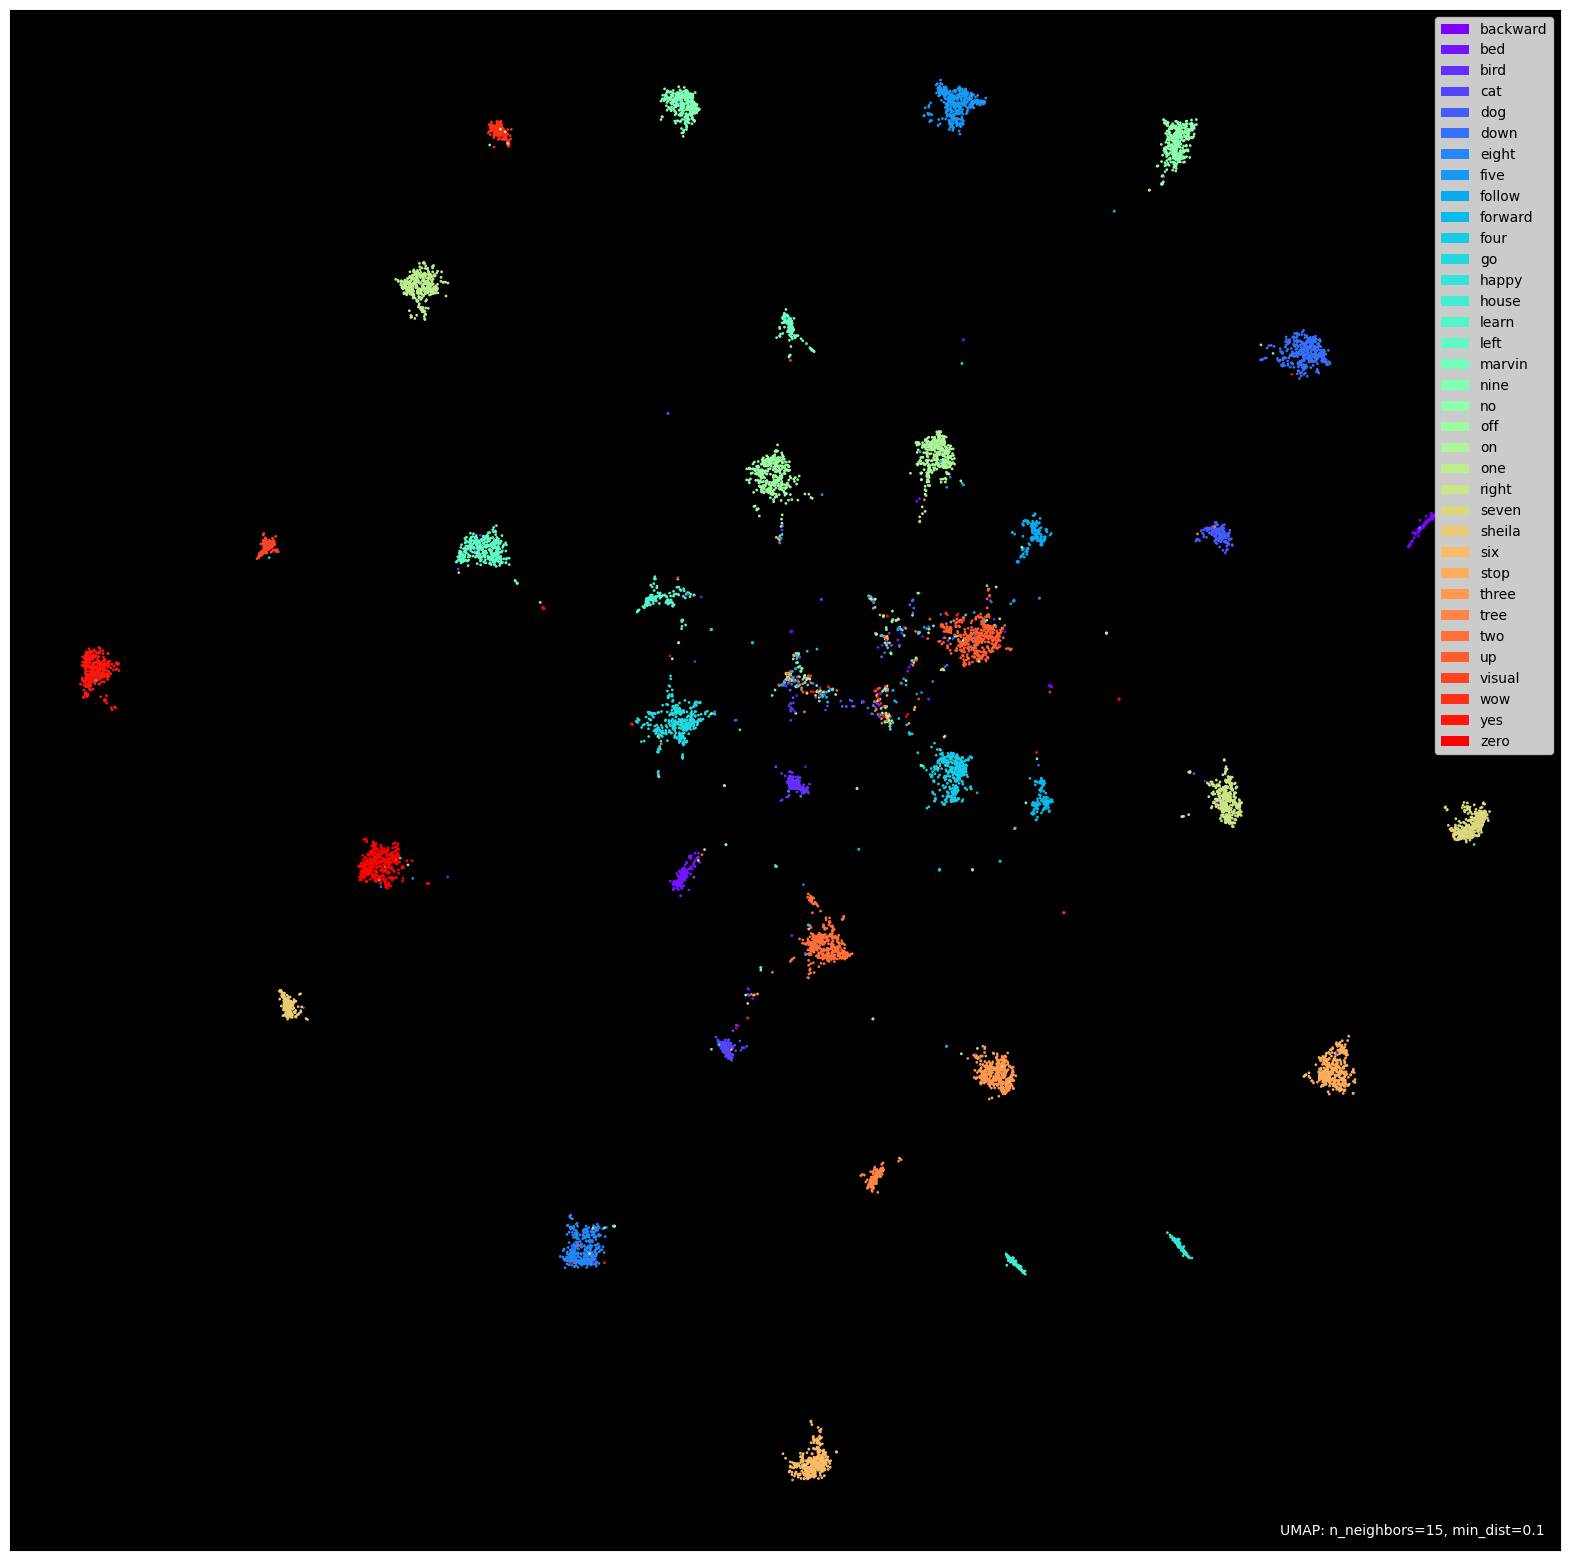

In [7]:
umap.plot.points(manifold, labels=np.array([labels_names[i] for i in model_labels]),width=2000,height=2000,theme="fire")

### PCA

In [28]:
pca3d = PCA(n_components=3)
pca2d = PCA(n_components=2)

transformed_data_3d = pca3d.fit_transform(model_logits)
transformed_data_2d = pca2d.fit_transform(model_logits)

In [26]:
# Define colors for each class
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
          '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create a trace for each class
traces = []
for i, color in enumerate(colors):
    class_data = transformed_data_3d[model_labels == i]
    trace = go.Scatter3d(
        x=class_data[:, 0],
        y=class_data[:, 1],
        z=class_data[:, 2],
        mode='markers',
        marker=dict(color=color, size=2),
        name=f'Class {i}'
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='PCA 3D Visualization'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()

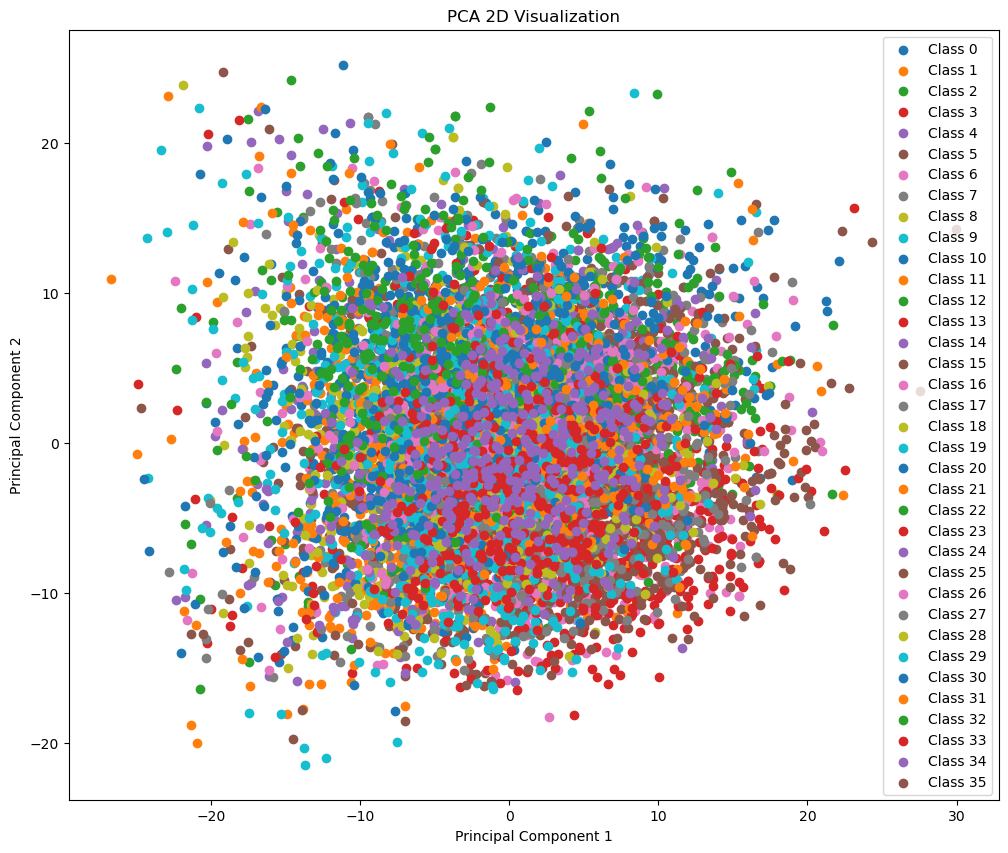

In [30]:
plt.figure(figsize=(12,10))

# Plot the transformed data points with different colors for each class
for i, color in enumerate(colors):
    class_data = transformed_data_2d[model_labels == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=color, label=f'Class {i}')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Visualization')

# Add a legend
plt.legend()

# Show the plot
plt.show()
